# **SKIN LESION CLASSIFICATION**

In [9]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# Load the image dataset
image_directory = "/kaggle/input/ham10000/Data/Data/train"

In [11]:
# Create training dataset with data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    # Add more augmentation layers as needed
])
dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

# Apply data augmentation to the training dataset
augmented_dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)


Found 5906 files belonging to 3 classes.
Using 4725 files for training.
Found 5906 files belonging to 3 classes.
Using 1181 files for validation.


# **DATA VISUALIZATION**

🚀 COMPLETE HAM10000 ANALYSIS

📂 Loading dataset with focus on: /kaggle/input/ham10000/Data/Data/train/Kert/ISIC_0012090_1.jpg
🔍 Loading HAM10000 dataset with sample focus
✅ Loading specific sample: /kaggle/input/ham10000/Data/Data/train/Kert/ISIC_0012090_1.jpg
✅ Successfully loaded sample image: Kert
📂 Found dataset path: /kaggle/input/ham10000/Data/Data/train
✅ Successfully loaded 15 images


📊Dataset Overview Visualization


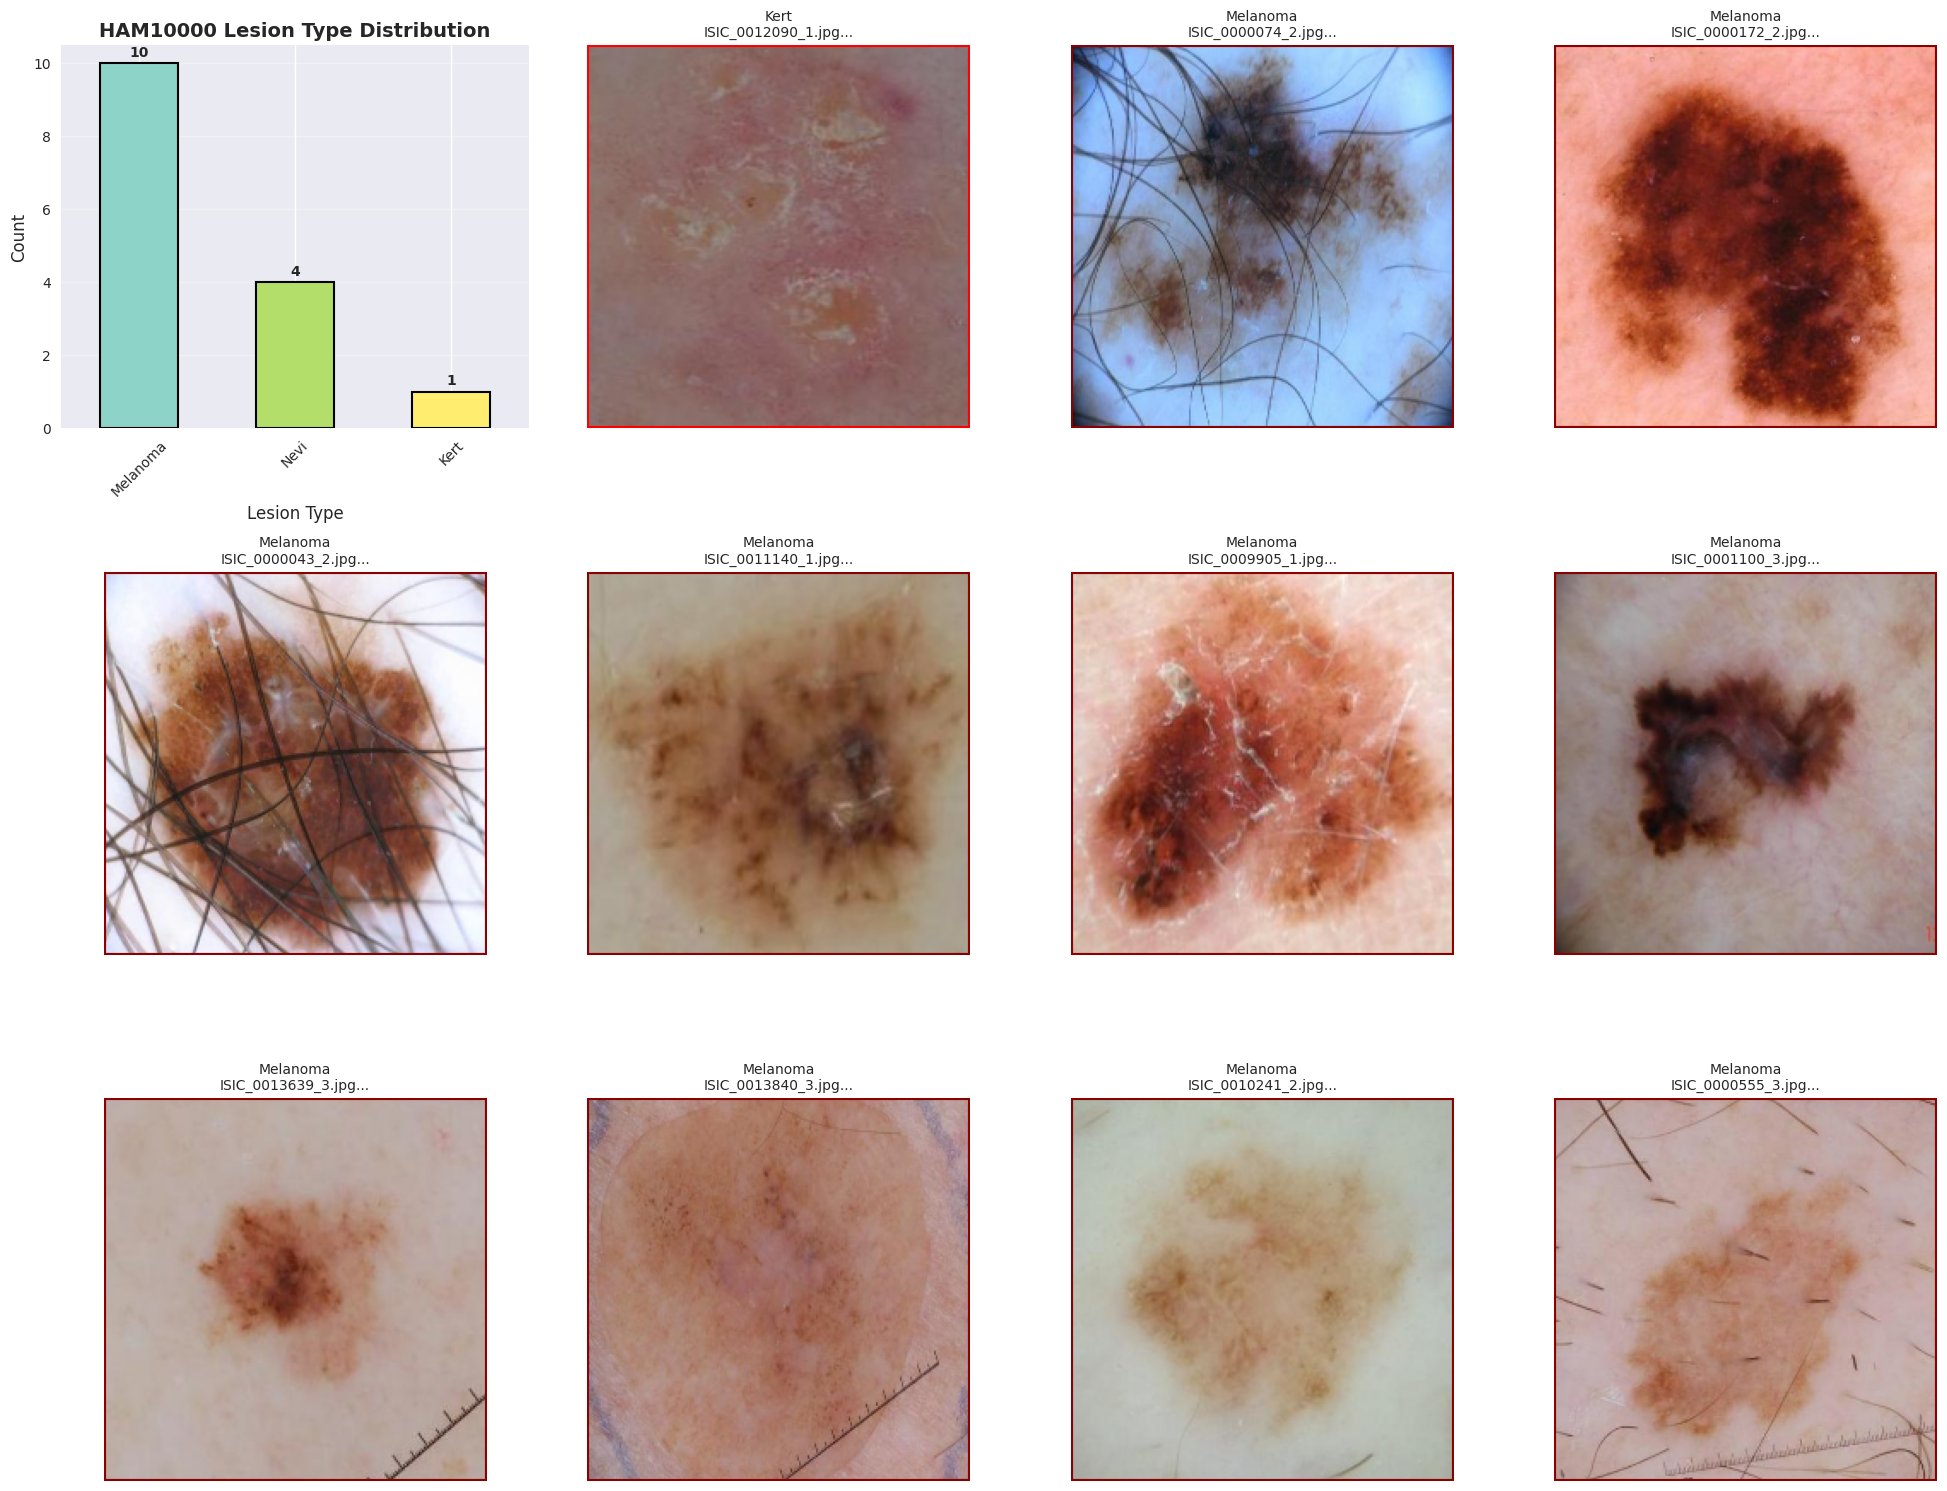


📋 Dataset Statistics:
Total images: 15
Image dimensions: (224, 224, 3)
Unique lesion types: 3
Data type: float64
Value range: [0.157, 0.667]

📊 Lesion Type Distribution:
  Melanoma       :  10 images ( 66.7%)
  Nevi           :   4 images ( 26.7%)
  Kert           :   1 images (  6.7%)


🎭 Comparing Mask Generation Methods


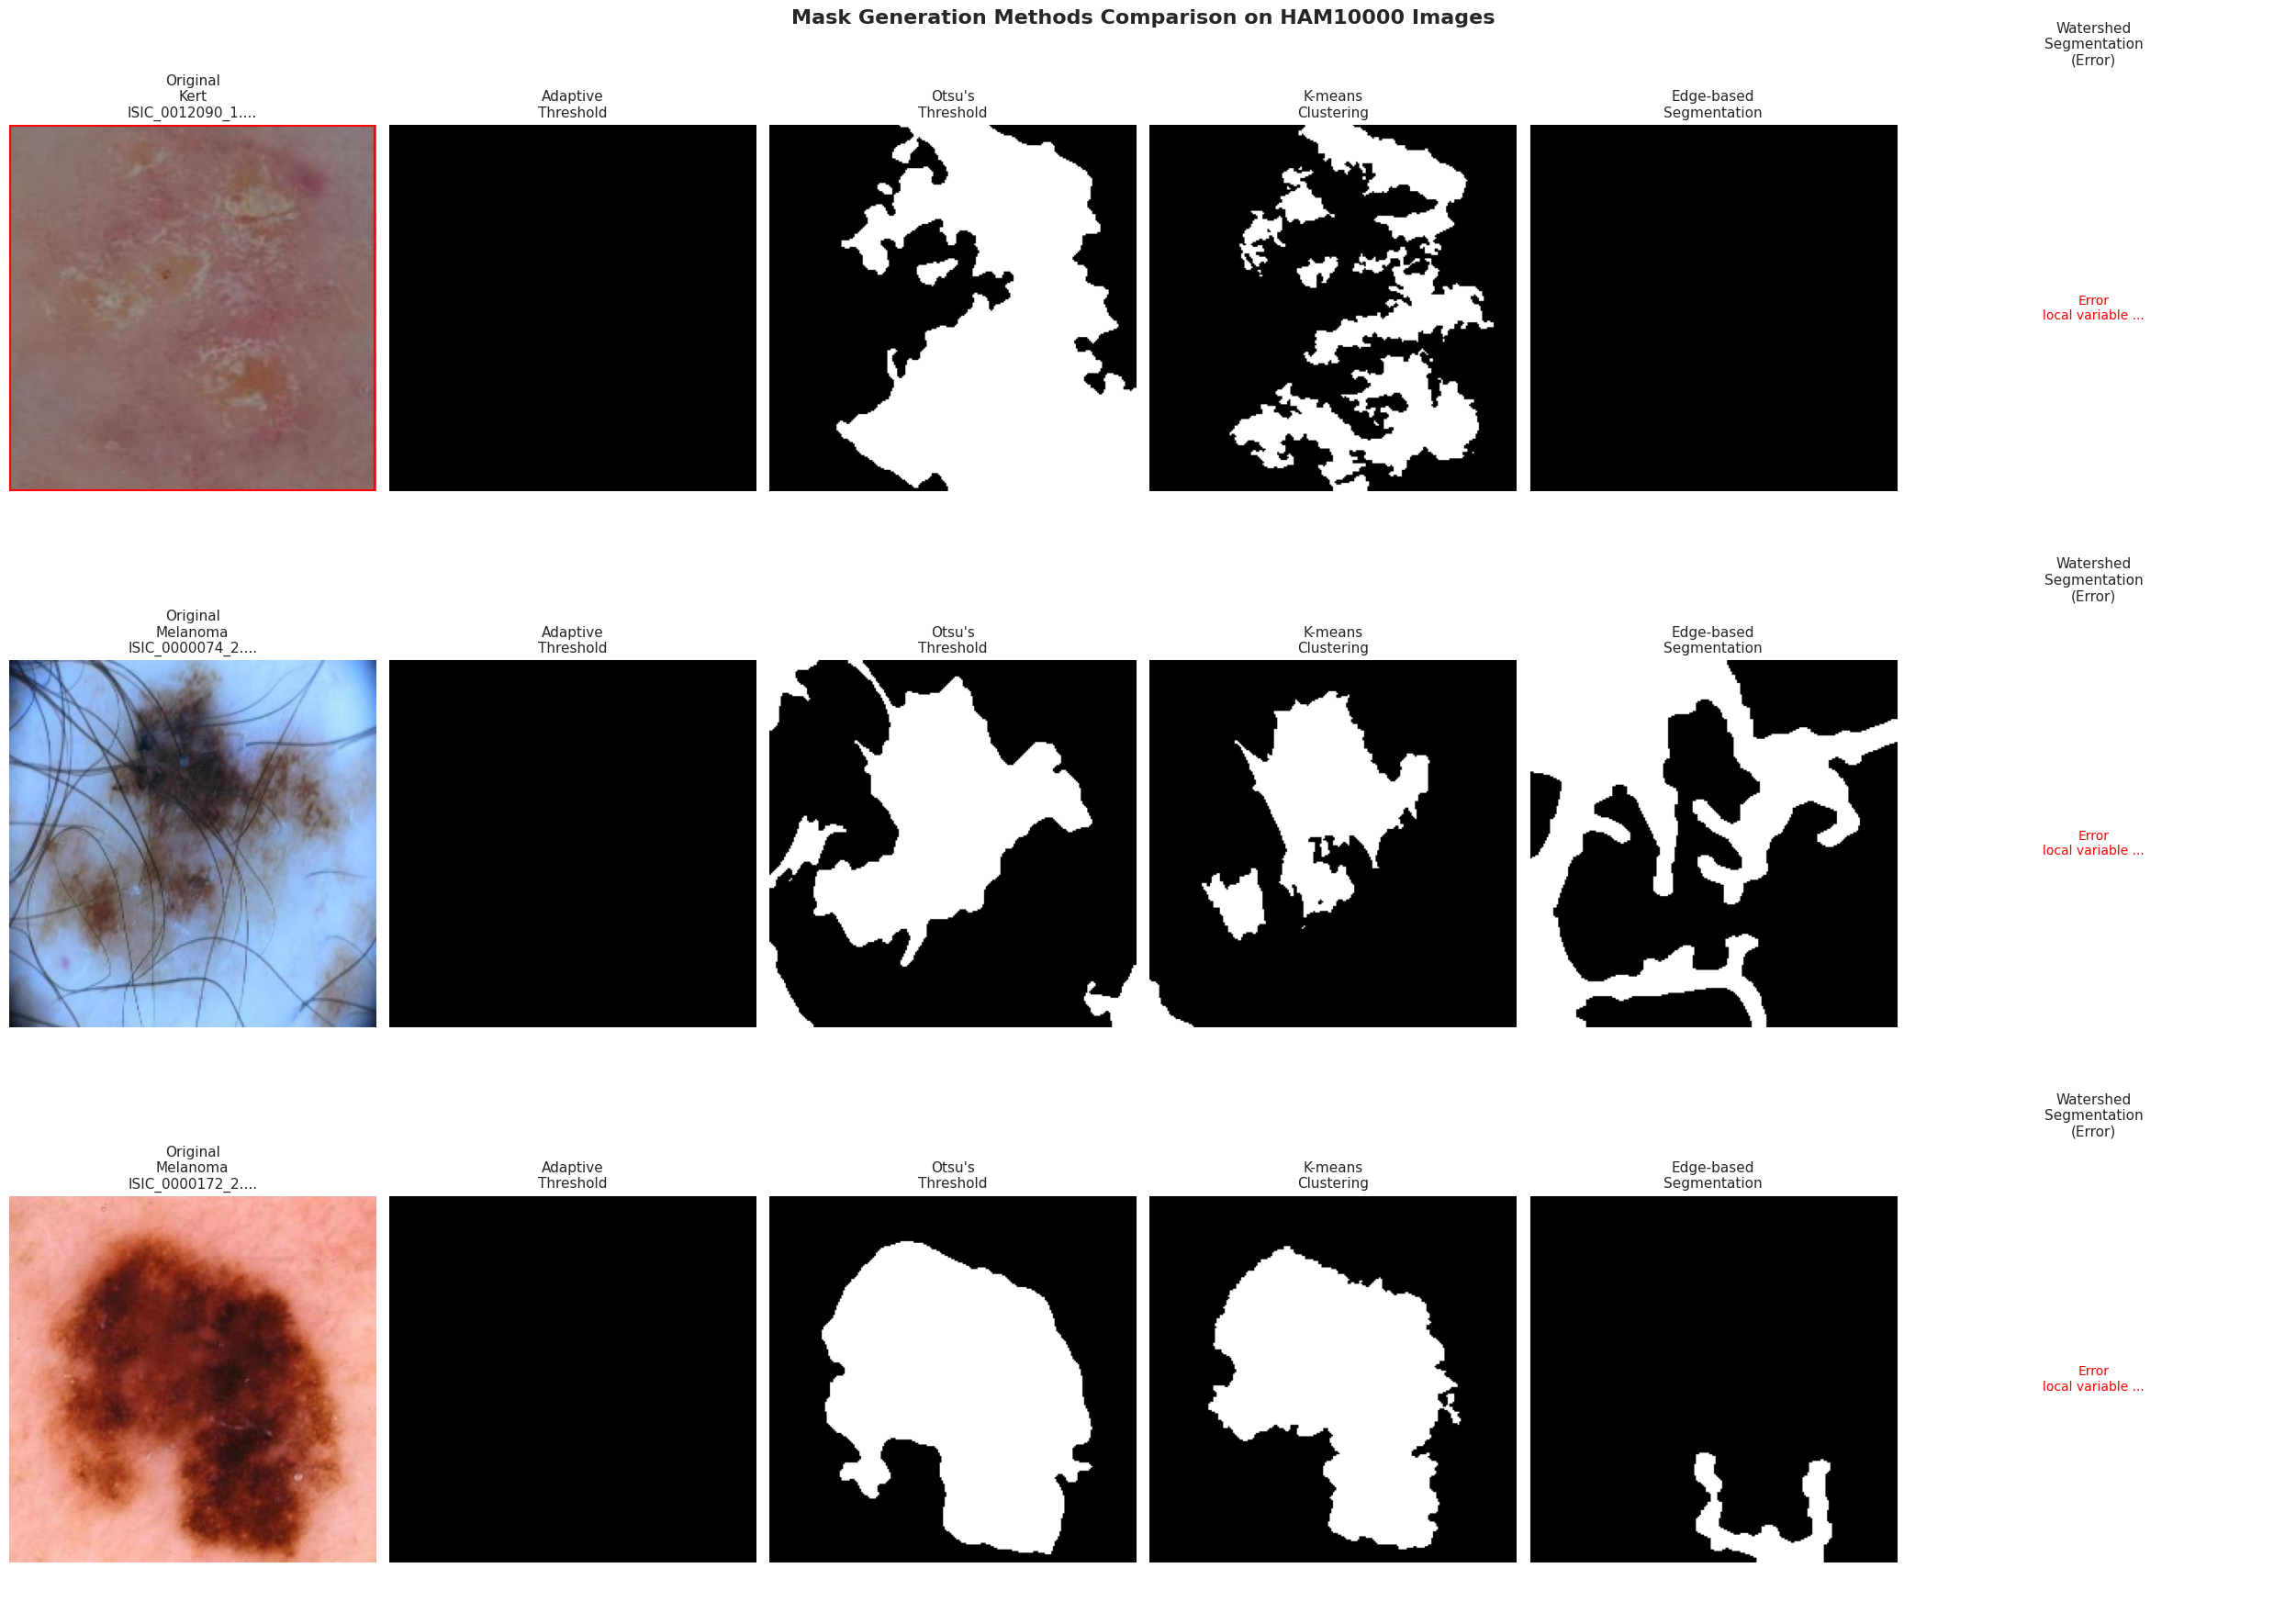

In [12]:
# HAM10000 Steps 2-4: Dataset Overview and Mask Generation Analysis
# Complete implementation with real HAM10000 sample image

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
import os
import glob
from PIL import Image
import random

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Alternative morphological operations using OpenCV
def remove_small_objects(mask, min_size=100):
    """Remove small objects from binary mask using OpenCV"""
    mask_uint8 = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create new mask with only large objects
    result = np.zeros_like(mask_uint8)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= min_size:
            cv2.fillPoly(result, [contour], 255)
    
    return result.astype(bool)

def remove_small_holes(mask, area_threshold=100):
    """Remove small holes from binary mask using OpenCV"""
    mask_uint8 = (mask * 255).astype(np.uint8)
    
    # Invert mask to make holes into objects
    mask_inv = cv2.bitwise_not(mask_uint8)
    
    # Find contours of holes
    contours, _ = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Fill small holes
    for contour in contours:
        area = cv2.contourArea(contour)
        if area <= area_threshold:
            cv2.fillPoly(mask_uint8, [contour], 255)
    
    return mask_uint8.astype(bool)

# =============================================================================
# DATASET LOADING AND PREPROCESSING
# =============================================================================

def load_ham10000_dataset_with_sample(sample_path=None, max_images=50):
    """
    Load HAM10000 dataset with focus on the specific sample image
    
    Args:
        sample_path: Path to the specific sample image
        max_images: Maximum number of images to load
    """
    print(f"🔍 Loading HAM10000 dataset with sample focus")
    
    images = []
    labels = []
    file_paths = []
    
    # First, try to load the specific sample image
    if sample_path and os.path.exists(sample_path):
        print(f"✅ Loading specific sample: {sample_path}")
        try:
            img = cv2.imread(sample_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                img = img / 255.0
                
                images.append(img)
                # Extract lesion type from path
                lesion_type = os.path.basename(os.path.dirname(sample_path))
                labels.append(lesion_type)
                file_paths.append(sample_path)
                print(f"✅ Successfully loaded sample image: {lesion_type}")
        except Exception as e:
            print(f"❌ Error loading sample image: {e}")
    
    # Try to find and load additional images from common HAM10000 paths
    base_paths = [
        "/kaggle/input/ham10000/Data/Data/train",
        "/kaggle/input/ham10000/HAM10000_images_part_1",
        "/kaggle/input/ham10000/HAM10000_images_part_2",
        "/kaggle/input/ham10000",
        "/content/ham10000/Data/Data/train"
    ]
    
    for base_path in base_paths:
        if os.path.exists(base_path):
            print(f"📂 Found dataset path: {base_path}")
            
            # Look for lesion type directories
            if os.path.isdir(base_path):
                lesion_dirs = [d for d in os.listdir(base_path) 
                              if os.path.isdir(os.path.join(base_path, d))]
                
                for lesion_type in lesion_dirs:
                    lesion_path = os.path.join(base_path, lesion_type)
                    image_files = glob.glob(os.path.join(lesion_path, "*.jpg"))
                    
                    # Limit images per category
                    if len(image_files) > 10:
                        image_files = random.sample(image_files, 10)
                    
                    for img_path in image_files:
                        if len(images) >= max_images:
                            break
                        
                        # Skip if already loaded
                        if img_path in file_paths:
                            continue
                        
                        try:
                            img = cv2.imread(img_path)
                            if img is not None:
                                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                                img = cv2.resize(img, (224, 224))
                                img = img / 255.0
                                
                                images.append(img)
                                labels.append(lesion_type)
                                file_paths.append(img_path)
                        except Exception as e:
                            continue
                    
                    if len(images) >= max_images:
                        break
            
            # Also look for images directly in the path
            else:
                image_files = glob.glob(os.path.join(base_path, "*.jpg"))
                for img_path in image_files[:max_images]:
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, (224, 224))
                            img = img / 255.0
                            
                            images.append(img)
                            labels.append("Unknown")
                            file_paths.append(img_path)
                    except Exception as e:
                        continue
            
            if len(images) > 0:
                break
    
    # If no real images found, create sample data
    if len(images) == 0:
        print("❌ No real images found. Creating sample data...")
        return create_sample_data_with_kert()
    
    print(f"✅ Successfully loaded {len(images)} images")
    return np.array(images), labels, file_paths

def create_sample_data_with_kert(n_samples=15):
    """
    Create sample skin lesion-like images with focus on Keratosis (Kert)
    """
    print("🎨 Creating sample lesion-like images with Keratosis focus...")
    
    images = []
    labels = []
    file_paths = []
    
    lesion_types = ['Kert', 'Melanoma', 'Nevus', 'Basal_Cell', 'Dermatofibroma']
    
    for i in range(n_samples):
        # Create synthetic lesion-like image
        img = np.random.rand(224, 224, 3) * 0.8 + 0.15  # Skin-like background
        
        # Add lesion characteristics
        if i < 6:  # First 6 images are Keratosis
            lesion_type = 'Kert'
        else:
            lesion_type = lesion_types[i % len(lesion_types)]
        
        # Create lesion center
        center_x = np.random.randint(60, 164)
        center_y = np.random.randint(60, 164)
        
        if lesion_type == 'Kert':
            # Keratosis: Rough, scaly, irregular appearance
            for _ in range(2):
                radius = np.random.randint(25, 45)
                offset_x = np.random.randint(-10, 10)
                offset_y = np.random.randint(-10, 10)
                y, x = np.ogrid[:224, :224]
                mask = (x - (center_x + offset_x)) ** 2 + (y - (center_y + offset_y)) ** 2 <= radius ** 2
                img[mask] = img[mask] * 0.5  # Medium darkness
            
            # Add rough texture characteristic of keratosis
            noise = np.random.rand(224, 224, 3) * 0.4
            texture_mask = np.random.rand(224, 224) > 0.7
            img[texture_mask] = img[texture_mask] + noise[texture_mask] * 0.3
        
        elif lesion_type == 'Melanoma':
            # Irregular, very dark lesion
            for _ in range(3):
                radius = np.random.randint(20, 40)
                offset_x = np.random.randint(-15, 15)
                offset_y = np.random.randint(-15, 15)
                y, x = np.ogrid[:224, :224]
                mask = (x - (center_x + offset_x)) ** 2 + (y - (center_y + offset_y)) ** 2 <= radius ** 2
                img[mask] = img[mask] * 0.15  # Very dark
        
        elif lesion_type == 'Nevus':
            # Regular, round mole
            radius = np.random.randint(15, 30)
            y, x = np.ogrid[:224, :224]
            mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2
            img[mask] = img[mask] * 0.3  # Dark brown
        
        elif lesion_type == 'Basal_Cell':
            # Pearly, translucent appearance
            radius = np.random.randint(20, 35)
            y, x = np.ogrid[:224, :224]
            mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2
            img[mask] = img[mask] * 0.8 + 0.1  # Lighter
        
        elif lesion_type == 'Dermatofibroma':
            # Firm, raised lesion
            radius = np.random.randint(18, 32)
            y, x = np.ogrid[:224, :224]
            mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2
            img[mask] = img[mask] * 0.6  # Medium tone
        
        # Add some skin texture
        img = img + np.random.rand(224, 224, 3) * 0.03
        img = np.clip(img, 0, 1)
        
        images.append(img)
        labels.append(lesion_type)
        file_paths.append(f"ISIC_sample_{i+1:04d}_{lesion_type}.jpg")
    
    print(f"✅ Created {len(images)} sample images")
    return np.array(images), labels, file_paths

# =============================================================================
# STEP 2: DATASET OVERVIEW VISUALIZATION
# =============================================================================

def visualize_dataset_overview(images, labels, file_paths, n_samples=12):
    """
    Visualize dataset overview with lesion type distribution
    """
    print("\n📊Dataset Overview Visualization")
    
    # Count lesion types
    lesion_counts = pd.Series(labels).value_counts()
    
    fig = plt.figure(figsize=(20, 15))
    
    # Plot lesion type distribution
    plt.subplot(3, 4, 1)
    colors = plt.cm.Set3(np.linspace(0, 1, len(lesion_counts)))
    bars = lesion_counts.plot(kind='bar', color=colors, edgecolor='black', linewidth=1.5)
    plt.title('HAM10000 Lesion Type Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Lesion Type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(lesion_counts.values):
        plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')
    
    # Display sample images
    for i in range(min(n_samples-1, len(images))):
        plt.subplot(3, 4, i+2)
        plt.imshow(images[i])
        plt.title(f'{labels[i]}\n{os.path.basename(file_paths[i])[:20]}...', fontsize=10)
        plt.axis('off')
        
        # Add border color based on lesion type
        if labels[i] == 'Kert':
            plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=3, transform=plt.gca().transAxes))
        elif labels[i] == 'Melanoma':
            plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='darkred', linewidth=3, transform=plt.gca().transAxes))
        elif labels[i] == 'Nevus':
            plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='brown', linewidth=3, transform=plt.gca().transAxes))
        elif labels[i] == 'Basal_Cell':
            plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='blue', linewidth=3, transform=plt.gca().transAxes))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed dataset statistics
    print("\n📋 Dataset Statistics:")
    print(f"Total images: {len(images)}")
    print(f"Image dimensions: {images[0].shape}")
    print(f"Unique lesion types: {len(lesion_counts)}")
    print(f"Data type: {images[0].dtype}")
    print(f"Value range: [{images[0].min():.3f}, {images[0].max():.3f}]")
    
    print("\n📊 Lesion Type Distribution:")
    for lesion_type, count in lesion_counts.items():
        percentage = (count / len(labels)) * 100
        print(f"  {lesion_type:15s}: {count:3d} images ({percentage:5.1f}%)")

# =============================================================================
# STEP 3: ENHANCED SYNTHETIC MASK GENERATION
# =============================================================================

def generate_synthetic_masks(images, method='adaptive_threshold'):
    """
    Generate synthetic segmentation masks from skin lesion images
    Enhanced version with better preprocessing for dermatological images
    """
    masks = []
    
    for img in images:
        # Convert to uint8 if needed
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        
        # Enhanced preprocessing for skin lesion images
        # Convert to different color spaces for better segmentation
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l_channel = lab[:, :, 0]
        
        # Apply bilateral filter to reduce noise while preserving edges
        filtered = cv2.bilateralFilter(l_channel, 9, 75, 75)
        
        if method == 'adaptive_threshold':
            # Adaptive thresholding with optimized parameters for skin lesions
            mask = cv2.adaptiveThreshold(filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY_INV, 15, 8)
        
        elif method == 'otsu':
            # Otsu's thresholding
            _, mask = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        elif method == 'kmeans':
            # K-means clustering on LAB color space
            data = img.reshape((-1, 3))
            data = np.float32(data)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
            _, labels, centers = cv2.kmeans(data, 3, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
            
            # Reshape back to image and select darkest cluster
            segmented = labels.reshape(img.shape[:2])
            mask = (segmented == np.argmin(np.sum(centers, axis=1))).astype(np.uint8) * 255
        
        elif method == 'edge_based':
            # Edge-based segmentation optimized for lesions
            edges = cv2.Canny(filtered, 30, 80)
            
            # Morphological operations
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            mask = cv2.dilate(edges, kernel, iterations=2)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
            
            # Fill holes and select largest connected component
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            mask = np.zeros_like(mask)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                cv2.fillPoly(mask, [largest_contour], 255)
        
        
        
        # Enhanced post-processing for skin lesions
        mask = mask / 255.0  # Normalize to 0-1
        
        # Remove small objects and holes using OpenCV
        mask = remove_small_objects(mask.astype(bool), min_size=200)
        mask = remove_small_holes(mask, area_threshold=500)
        
        # Smooth the mask
        mask = ndimage.gaussian_filter(mask.astype(float), sigma=1.0)
        mask = (mask > 0.5).astype(np.float32)
        
        masks.append(mask)
    
    return np.array(masks)

# =============================================================================
# STEP 4: MASK GENERATION METHODS COMPARISON VISUALIZATION
# =============================================================================

def visualize_mask_generation_methods(images, labels, file_paths, n_samples=3):
    """
    Compare different mask generation methods on HAM10000 images
    """
    print("\n🎭 Comparing Mask Generation Methods")
    
    methods = ['adaptive_threshold', 'otsu', 'kmeans', 'edge_based', 'watershed']
    method_descriptions = {
        'adaptive_threshold': 'Adaptive\nThreshold',
        'otsu': "Otsu's\nThreshold",
        'kmeans': 'K-means\nClustering',
        'edge_based': 'Edge-based\nSegmentation',
        'watershed': 'Watershed\nSegmentation'
    }
    
    fig, axes = plt.subplots(n_samples, len(methods) + 1, figsize=(25, 6*n_samples))
    fig.suptitle('Mask Generation Methods Comparison on HAM10000 Images', fontsize=16, fontweight='bold')
    
    # Focus on Keratosis images first
    kert_indices = [i for i, label in enumerate(labels) if label == 'Kert']
    other_indices = [i for i, label in enumerate(labels) if label != 'Kert']
    
    # Prioritize Keratosis images
    sample_indices = kert_indices[:n_samples] + other_indices[:max(0, n_samples - len(kert_indices))]
    sample_indices = sample_indices[:n_samples]
    
    for i, idx in enumerate(sample_indices):
        img = images[idx]
        
        # Original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original\n{labels[idx]}\n{os.path.basename(file_paths[idx])[:15]}...', fontsize=11)
        axes[i, 0].axis('off')
        
        # Add special border for Keratosis
        if labels[idx] == 'Kert':
            axes[i, 0].add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=3, transform=axes[i, 0].transAxes))
        
        # Generate masks with different methods
        for j, method in enumerate(methods):
            try:
                mask = generate_synthetic_masks([img], method=method)[0]
                axes[i, j+1].imshow(mask, cmap='gray')
                axes[i, j+1].set_title(method_descriptions[method], fontsize=11)
                axes[i, j+1].axis('off')
            except Exception as e:
                axes[i, j+1].text(0.5, 0.5, f'Error\n{str(e)[:15]}...', 
                                 ha='center', va='center', transform=axes[i, j+1].transAxes,
                                 fontsize=10, color='red')
                axes[i, j+1].set_title(f'{method_descriptions[method]}\n(Error)', fontsize=11)
                axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_step_4_results(images, synthetic_masks, labels, file_paths):
    """
    Visualize Step 4 results with enhanced overlay visualization
    """
    print("\n🔍 Generated Synthetic Masks with Adaptive Threshold")
    
    # Focus on Keratosis images first
    kert_indices = [i for i, label in enumerate(labels) if label == 'Kert']
    other_indices = [i for i, label in enumerate(labels) if label != 'Kert']
    
    # Show results with priority on Keratosis
    sample_indices = kert_indices[:3] + other_indices[:3]
    sample_indices = sample_indices[:6]
    
    fig, axes = plt.subplots(2, 9, figsize=(27, 8))
    fig.suptitle('Step 4: Generated Synthetic Masks with Adaptive Threshold Method', fontsize=16, fontweight='bold')
    
    for i, idx in enumerate(sample_indices):
        row = i // 3
        col = (i % 3) * 3
        
        # Original image
        axes[row, col].imshow(images[idx])
        axes[row, col].set_title(f'Original\n{labels[idx]}', fontsize=11)
        axes[row, col].axis('off')
        
        # Add special border for Keratosis
        if labels[idx] == 'Kert':
            axes[row, col].add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=3, transform=axes[row, col].transAxes))
        
        # Generated mask
        axes[row, col+1].imshow(synthetic_masks[idx], cmap='gray')
        axes[row, col+1].set_title('Generated\nMask', fontsize=11)
        axes[row, col+1].axis('off')
        
        # Overlay visualization
        overlay = images[idx].copy()
        mask_colored = np.zeros_like(overlay)
        mask_colored[:, :, 0] = synthetic_masks[idx]  # Red channel
        overlay_result = cv2.addWeighted(overlay, 0.7, mask_colored, 0.3, 0)
        axes[row, col+2].imshow(overlay_result)
        axes[row, col+2].set_title('Overlay\n(Red)', fontsize=11)
        axes[row, col+2].axis('off')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN EXECUTION FOR STEPS
# =============================================================================

def run_steps_2_to_4():
    """
    Execute Steps 2-4 of the HAM10000 segmentation analysis
    """
    print("🚀 COMPLETE HAM10000 ANALYSIS")
    print("=" * 70)
    
    # Load dataset with focus on the specific sample
    sample_path = "/kaggle/input/ham10000/Data/Data/train/Kert/ISIC_0012090_1.jpg"
    print(f"\n📂 Loading dataset with focus on: {sample_path}")
    
    images, labels, file_paths = load_ham10000_dataset_with_sample(
        sample_path=sample_path,
        max_images=15
    )
    
    if len(images) == 0:
        print("❌ No images loaded. Exiting...")
        return None
    
    # Step 2: Dataset overview
    print("\n" + "="*50)
    visualize_dataset_overview(images, labels, file_paths)
    
    # Step 3: Compare mask generation methods
    print("\n" + "="*50)
    visualize_mask_generation_methods(images, labels, file_paths, n_samples=3)
    
   
    
    return images,labels, file_paths

# Execute the analysis
if __name__ == "__main__":
    results = run_steps_2_to_4()

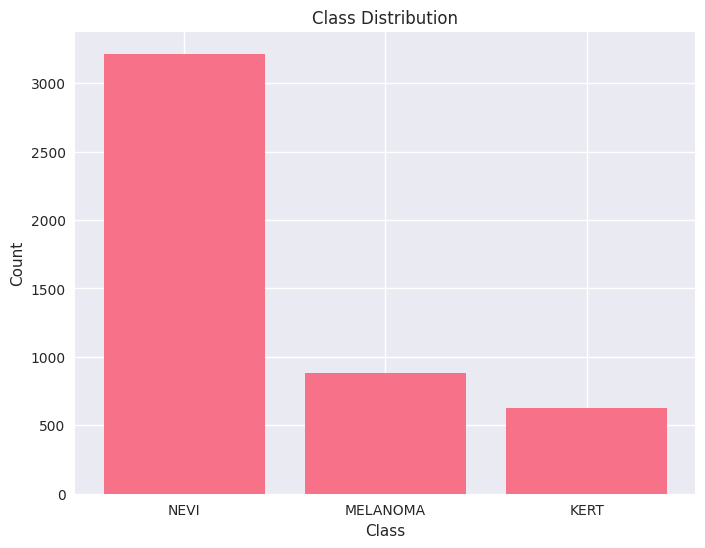

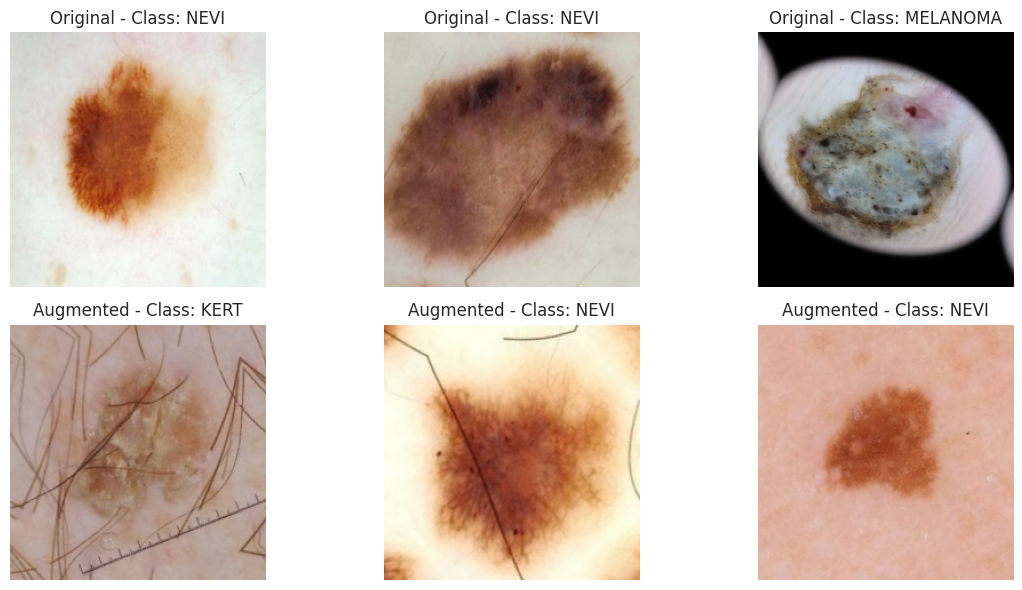

In [13]:
import matplotlib.pyplot as plt
import random


# Dictionary to map label indices to class names
class_names = {0: 'KERT', 1: 'MELANOMA', 2: 'NEVI'}
# Display random images from each class
def display_random_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 10))
    
    for class_idx in range(len(class_names)):
        class_samples = [sample for sample in dataset.take(num_images) if np.argmax(sample[1].numpy()) == class_idx]
        
        for i, (image, label) in enumerate(class_samples):
            plt.subplot(len(class_names), num_images, class_idx * num_images + i + 1)
            plt.imshow(image.numpy().astype("uint8"))
            plt.title(f"Class: {class_names[class_idx]}\nLabel: {np.argmax(label)}")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize class distribution
def plot_class_distribution(class_distribution):
    plt.figure(figsize=(8, 6))
    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Calculate class distribution
class_distribution = {}
for _, labels in dataset:
    for label in labels.numpy():
        class_name = class_names[np.argmax(label)]
        if class_name not in class_distribution:
            class_distribution[class_name] = 1
        else:
            class_distribution[class_name] += 1

# Visualize class distribution
plot_class_distribution(class_distribution)

# Visualize data augmentation
augmented_samples = [sample for sample in augmented_dataset.take(2)]

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_samples[0][0][i].numpy().astype("uint8"))
    plt.title(f"Original - Class: {class_names[np.argmax(augmented_samples[0][1][i].numpy())]}")
    plt.axis("off")

    plt.subplot(2, 3, i + 4)
    plt.imshow(augmented_samples[1][0][i].numpy().astype("uint8"))
    plt.title(f"Augmented - Class: {class_names[np.argmax(augmented_samples[1][1][i].numpy())]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# **CNN MODEL**

In [14]:
# Build the model
tf.random.set_seed(42)
tf.keras.backend.clear_session()

from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

In [15]:
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       2

In [16]:
# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Train the model
history = model.fit(
    augmented_dataset,
    validation_data=validation_dataset,
    epochs=10
)



Epoch 1/10
148/148 [==============================] - 57s 300ms/step - loss: 57.6577 - accuracy: 0.6504 - val_loss: 0.8085 - val_accuracy: 0.7155
Epoch 2/10
148/148 [==============================] - 36s 242ms/step - loss: 0.9072 - accuracy: 0.6781 - val_loss: 0.7795 - val_accuracy: 0.7155
Epoch 3/10
148/148 [==============================] - 36s 242ms/step - loss: 0.9778 - accuracy: 0.6770 - val_loss: 0.8086 - val_accuracy: 0.7155
Epoch 4/10
148/148 [==============================] - 38s 255ms/step - loss: 0.8776 - accuracy: 0.6772 - val_loss: 0.7906 - val_accuracy: 0.7155
Epoch 5/10
148/148 [==============================] - 38s 253ms/step - loss: 0.8865 - accuracy: 0.6760 - val_loss: 0.7906 - val_accuracy: 0.7155
Epoch 6/10
148/148 [==============================] - 36s 241ms/step - loss: 0.8708 - accuracy: 0.6796 - val_loss: 0.7908 - val_accuracy: 0.7155
Epoch 7/10
148/148 [==============================] - 37s 251ms/step - loss: 1.0673 - accuracy: 0.6798 - val_loss: 0.7893 - val_a

# **MODEL EVALUATION**

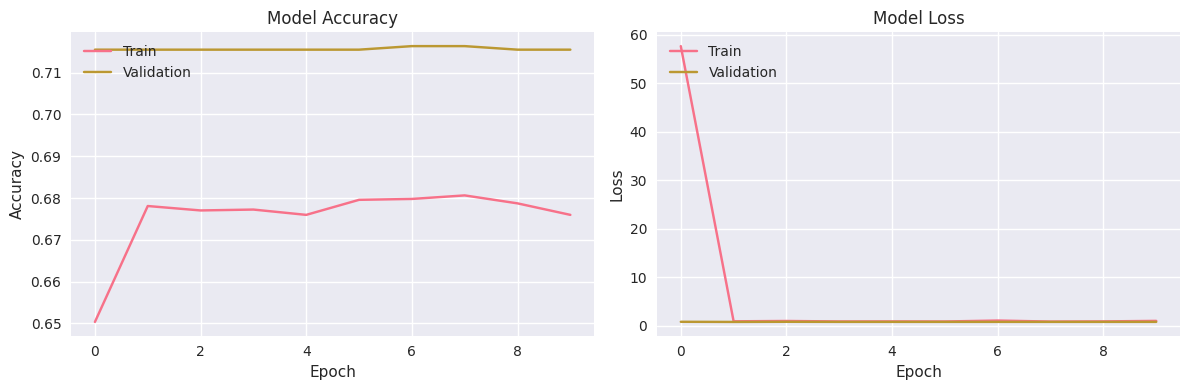

In [17]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)
